In [150]:
from lib import *

Pipeline = pipeline.Pipeline
RegressionValidator = pipeline.RegressionValidator

DatasetProvider = provider.DatasetProvider
DatasetUploader = provider.DatasetUploader
ExpandedWindowIterator = subset_extraction.ExpandedWindowIterator
EntityIterator = subset_extraction.EntityIterator

In [151]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy
from scipy import stats

import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

tr = transformers

In [152]:
CONFIG = {
    'validation_window': {
        'min_window': 13,
        'max_window': 32,
    },
    'training_window': {
        'min': 16
    },
    'FETCH_DATA': False,
}

In [153]:
df_provider = DatasetProvider()

In [154]:
dataset_paths = [
    '/home/denissimo/Repo/fs_project/datasets/sample_submission.csv',
    '/home/denissimo/Repo/fs_project/datasets/test.csv',
    '/home/denissimo/Repo/fs_project/datasets/shops.csv',
    '/home/denissimo/Repo/fs_project/datasets/item_categories.csv',
    '/home/denissimo/Repo/fs_project/datasets/sales_train.csv',
    '/home/denissimo/Repo/fs_project/datasets/items.csv'
]

In [155]:
df_provider.file_list = dataset_paths

datasets = df_provider.get_dataset()

In [156]:
sales = datasets['sales_train.csv']
items = datasets['items.csv']
categories = datasets['item_categories.csv']
shops = datasets['shops.csv']

In [157]:
sales.date = sales.date.astype('datetime64[ns]')

print("Before:", sales.shape)

from datetime import date

sales = sales.loc[sales.date < np.datetime64(date(2015, 11, 1))]

sales_train = sales[
    (sales["item_cnt_day"] < 1000)
    & (sales["item_price"] > 0)
    & (sales["item_price"] < 60000)
].copy()
print("After:", sales_train.shape)

sales.head()

Before: (2935849, 6)
After: (2896778, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [158]:
import pickle

def load_pickle(dataset, name):
    dataset.to_pickle(name + '.pkl')

def from_pickle(path):
    with open(path, 'rb') as reader:
        return pickle.load(reader)

In [159]:
index_preprocessing = {}

index_preprocessing['id_merging_stage'] = lambda dataset: dataset.merge(
    shops,
    how='cross'
).merge(
    categories,
    on='item_category_id'
).reset_index().rename({'index': 'id'}, axis=1)



In [160]:
task_df = {}

In [161]:
task_df['idx'] = index_preprocessing['id_merging_stage'](items)

In [162]:
data_preprocessing = {}

# Add corresponding category and shop id's to each sale
data_preprocessing['id_merging_stage'] = lambda dataset: dataset.merge(
    items, 
    on='item_id'
).merge(
    shops,
    on='shop_id'
).merge(
    categories,
    on='item_category_id'
)

# Add summary among shop_id and category_id above similar time periods (daily intervals)
data_preprocessing['summarizing_and_name_merging_stage'] = lambda dataset: dataset.groupby(
    ['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id']
).agg({'item_cnt_day': np.sum, 'item_price': np.mean}).reset_index().sort_values('date')

data_preprocessing['date_block_num_renaming'] = lambda dataset: dataset.rename(columns={'date_block_num': 'month_block'}, inplace=True)

data_preprocessing['object_id_encoding'] = lambda dataset: dataset.merge(
    task_df['idx'][['id', 'shop_id', 'item_id']], 
    on=['shop_id', 'item_id'])

In [163]:
pipeline = Pipeline(
    tasks=data_preprocessing, 
    task_queue = [
        'id_merging_stage',
        'summarizing_and_name_merging_stage',
        'date_block_num_renaming',
        'object_id_encoding',
    ]
)

In [164]:
pipeline_test = pipeline(sales)
pipeline_train = pipeline(sales_train)

if not CONFIG['FETCH_DATA']:
    _ = pipeline_test.proceed_all()
    _ = pipeline_train.proceed_all()

Stage - id_merging_stage complete
Stage - summarizing_and_name_merging_stage complete
Stage - date_block_num_renaming complete
Stage - object_id_encoding complete
Stage - id_merging_stage complete
Stage - summarizing_and_name_merging_stage complete
Stage - date_block_num_renaming complete
Stage - object_id_encoding complete


In [165]:
if CONFIG['FETCH_DATA'] == False:
    task_df['test'] = pipeline_test.result_storage['object_id_encoding']
    task_df['train'] = pipeline_train.result_storage['object_id_encoding']
    load_pickle(task_df['test'], 'task_df_test')
    load_pickle(task_df['train'], 'task_df_train')
else:
    task_df['test'] = from_pickle('task_df_test.pkl')
    task_df['train'] = from_pickle('task_df_train.pkl')

## transformers.py

In [166]:
from statsmodels.tsa.stattools import acf 

# Useful wrapper
def make_transformer(func, **kwargs):
    def wrapped(*frames):
        return func(*frames, **kwargs)
    return wrapped

def extract_id_sequences(df, index=None, seq_index=None, target=None, aggregator=None, fill_na=np.NaN):
    return (
        df.groupby(index + seq_index)[target]
        .apply(aggregator)
        .reset_index()
        .pivot(
            index=index, 
            columns=seq_index, 
            values=target
            )
        .fillna(fill_na))

def diff(series, order, period=1):
    diff_1 = (series - series.shift(period, axis=1))
    if order == 1:
        return diff_1.fillna(0)
    elif order == 2:
        return (diff_1 - diff_1.shift(period, axis=1)).fillna(0)
    else:
        raise ValueError(f'Order higher than 2 is currently unsupported')

def subset2subset(df, series_transformer, column_names, axis=1):
    return df.apply(
        lambda _series: pd.Series(
            series_transformer(_series), 
            index=column_names), 
        axis=1, 
        result_type='expand')

def take_acf(series, nlags):    
    return acf(series, nlags=nlags)[1:]


def append_columns(dataset, columns, transformers):
    for column, transformer in zip(columns, transformers):
        dataset[column] = transformer(dataset)

## aggregators.py

In [328]:
def take_subseries(df, columns, new_name):
    if isinstance(columns, list): 
        return df.loc[:, columns].rename(dict([zip(columns, new_name)]))
    else:
        return df.loc[:, df.columns[columns]].rename(dict(zip(df.columns[columns], new_name)), axis=1)

def create_aggregation_pipeline(df, func_queue):
    dataset = df
    for func in func_queue:
        dataset = func(dataset)
    return dataset

def reorder_columns(df, new_order):
    return df.reindex(columns=new_order)

## extractor.py

In [168]:
# Full extraction cycle class 
class FeatureExtractor():

    class _SubframeGenerator():
        def __init__(self, tasks, building_context = {}, index=None):
            self._context = {
                'tasks': tasks,
            }
            self._results = building_context
            self._index = index

        def fit(self, df_set, target=None):
            self._results['id_subsets'] = {
                name: _set for name, _set in df_set.items() 
            }

            self._process_tasks()

        def _get_frames(self, names):
            try:
                return [self._results['id_subsets'][name] for name in names]
            except:
                raise

        def _process_tasks(self):
            for task_name, handler in self._context['tasks'].items():
                affected_serieses = self._get_frames(handler['serieses'])
                self._results['id_subsets'][task_name] = handler['executor'](*affected_serieses)
            return self._results['id_subsets']

    class _SubframeAggregator:
        def __init__(self, tasks, building_context = {}, index=None):
            self._context = {
                'tasks': tasks,
            }
            self._results = building_context
            self._index = index

        def fit(self, df=None, target=None):
            self._results['features'] = {}
            self._results['feature_map'] = {}
            
            self._process_tasks()

        def _process_tasks(self):
            pass

    class _TaskTranslator():
        @staticmethod
        def _process_subseries_cfg(cfg):
            translated = {}
            for task_name, encoded_task in cfg.items():
                translated[task_name] = {
                    'executor': make_transformer(encoded_task['func_name'], **encoded_task['params']),
                    'serieses': encoded_task['series_order'],
                }
            return translated

        @staticmethod
        def _process_feature_cfg(cfg):
            translated = {}
            for task in cfg:
                translated[task] = {
                    'executor': make_transformer(task['func_name'], **task['params']),
                    'from': task['from'],
                }
            return translated

    def __init__(self, subseries_cfg, feature_cfg, index) -> None:
        self._cfg = {
            'subserieses': self._TaskTranslator._process_subseries_cfg(subseries_cfg),
            'features': self._TaskTranslator._process_feature_cfg(feature_cfg),
            'index': index
        }

    def __call__(self, df):
        _building_context = {}

        subset_generator = self._SubframeGenerator(
            self._cfg['subserieses'],
            _building_context,
            self._cfg['index']
        )

        subset_generator.fit(df)

        return _building_context

## Configuration

In [248]:
full_cfg = {
    'id_sales': {
        'series_order': ['original'],
        'func_name': extract_id_sequences,
        'params': {
            'index': ['id'],
            'seq_index': ['month_block'],
            'target': 'item_cnt_day',
            'aggregator': np.sum,
            'fill_na': 0,
        }
    },
    'diff_1': {
        'series_order': ['id_sales'], 
        'func_name': diff,
        'params': {
            'order': 1
        }
    },
    'diff_2': {
        'series_order': ['id_sales'], 
        'func_name': diff,
        'params': {
            'order': 2
        }
    },
    'acf': {
        'series_order': ['id_sales'], 
        'func_name': subset2subset,
        'params': {
            'series_transformer': make_transformer(take_acf, nlags=12),
            'column_names': [f'series_acf_{i}' for i in range(1, 13)]
        }
    }
}

In [334]:
subset_cfg = {
    'id_sales': {
        'series_order': [],
        'func_name': from_pickle,
        'params': {
            'path': 'id_sales.pkl'
        }
    },
    'diff_1': {
        'series_order': ['id_sales'], 
        'func_name': diff,
        'params': {
            'order': 1
        }
    },
    'diff_2': {
        'series_order': ['id_sales'], 
        'func_name': diff,
        'params': {
            'order': 2
        }
    },
    'acf': {
        'series_order': [],
        'func_name': from_pickle,
        'params': {
            'path': 'acf.pkl'
        }
    },
    'lags': {
        'series_order': ['id_sales'],
        'func_name': create_aggregation_pipeline,
        'params': {
            'func_queue': [
                make_transformer(
                    take_subseries, 
                    columns=slice(-13, -1), 
                    new_name=[f'lag_{13 - i}' for i in range(1, 13)]),
                make_transformer(
                    reorder_columns,
                    new_order=[f'lag_{i}' for i in range(1, 13)])
            ]
        }
    },
    'lags_mul_acf': {
        'series_order': ['lags', ],
        'func_name': create_aggregation_pipeline,
        'params': {
            'columns': slice(-13, -1),
            'new_name': [f'acf_lag_{i}' for i in range(1, 13)]
        }
    }
}

aggregation_cfg = {
    'lags': {
        'from': ['id_sales'],
        'func_name': take_subseries,
        'params': {
            'columns': slice(-13, -1),
            'new_name': [f'lag_{13 - i}' for i in range(1, 13)]
        }
    }
}

In [339]:
extractor = FeatureExtractor(subset_cfg, {}, ['id'])

In [341]:
a['id_subsets']['lags']

month_block,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
id,,,,,,,,,,,,
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1330036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1330090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1330142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [340]:
a = extractor({
    'original': task_df['train']
})

In [231]:
serieses = task_df['train'].groupby(['month_block', 'id']).item_cnt_day.sum().reset_index().set_index('id').index.value_counts()

<AxesSubplot:xlabel='id', ylabel='Count'>

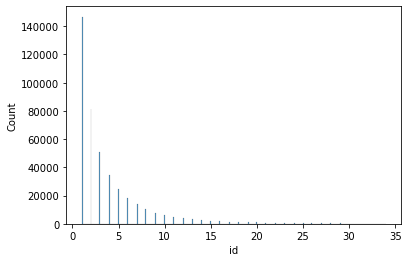

In [232]:
sns.histplot(serieses)

In [238]:
serieses[serieses.values == 34]

1228891    34
1317792    34
1229071    34
323851     34
1228966    34
           ..
1229055    34
427228     34
780382     34
1228995    34
1317492    34
Name: id, Length: 94, dtype: int64

In [247]:
id_and_month_covered = [
    serieses[serieses.values == i].index.to_list() for i in range(1, 35)
]

As we see more than 140k of (item_id, shop_id) pairs were seen once at a time, so we cannot predict them properly and maybe it would be better to drop them  